In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
from pandas.io.json import json_normalize
%matplotlib inline

# Data Acquisition

In [4]:
# Source URLs for pagecounts
mobile_cnts_url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/mobile-site/monthly/'
desktop_cnts_url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/desktop-site/monthly/'

# Source URLs for pageviews
desktop_views_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/desktop/user/monthly/'
mobile_webviews_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/mobile-web/user/monthly/'
mobile_appviews_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/mobile-app/user/monthly/'

all_urls = [mobile_cnts_url, desktop_cnts_url, desktop_views_url, mobile_webviews_url, mobile_appviews_url]
fnames = ['pagecounts_mobile-site', 'pagecounts_desktop-site', \
         'pageviews_desktop', 'pageviews_mobile-web', \
          'pageviews_mobile-app']

In [46]:
# Request using APIs and save as json files
start_pt = '2008010100'
end_pt = '2018093000'
url_suffix = start_pt + "/" + end_pt
for i in range(len(all_urls)):
    call = requests.get(all_urls[i] + url_suffix)
    fname = fnames[i] + "_" + start_pt[:-4] + "_" + end_pt[:-4] + ".json"
    f = open(fname, 'w')
    f.write(json.dumps(json.loads(call.content)))
    print(fname + ' saved successfully!')
    f.close()

pagecounts_mobile-site_200801_201809.json saved successfully!
pagecounts_desktop-site_200801_201809.json saved successfully!
pageviews_desktop_200801_201809.json saved successfully!
pageviews_mobile-web_200801_201809.json saved successfully!
pageviews_mobile-app_200801_201809.json saved successfully!


# Data Processing

In [107]:
# Function to load the json as dataframe and do initial pre-processing
def normalize_json(df):
    for i in range(len(df)):
        if i==0:
            df_new = json_normalize(df['items'][0])
        else:
            df_new = pd.concat([df_new, json_normalize(df['items'][i])])
    df_new['year'] = df_new['timestamp'].apply(lambda x: x[:4])
    df_new['month'] = df_new['timestamp'].apply(lambda x: x[4:6])
    df_new = df_new.drop(['timestamp', 'granularity', 'project'], axis=1)
    return df_new

In [112]:
# Load raw json files and pre-process the data
df1 = pd.read_json('pageviews_mobile-app_200801_201809.json')
df2 = pd.read_json('pageviews_mobile-web_200801_201809.json')
df3 = pd.read_json('pageviews_desktop_200801_201809.json')
df4 = pd.read_json('pagecounts_desktop-site_200801_201809.json')
df5 = pd.read_json('pagecounts_mobile-site_200801_201809.json')

df1 = normalize_json(df1)
df1 = df1.drop(['agent'], axis=1)
df1['views'].apply(lambda x: int(x))
df2 = normalize_json(df2)
df2 = df2.drop(['agent'], axis=1)
df2['views'].apply(lambda x: int(x))
df3 = normalize_json(df3)
df3 = df3.drop(['agent'], axis=1)
df3['views'].apply(lambda x: int(x))

df4 = normalize_json(df4)
df4['count'].apply(lambda x: int(x))
df5 = normalize_json(df5)
df5['count'].apply(lambda x: int(x))
print('Done!')

Done!


In [113]:
# Combine mobile app and mobile web view counts
df1['views'] = df1['views'] + df2['views']
df1['access'] = 'mobile'

In [152]:
# Generate the final csv data list

final_csv = {'year' : [], 'month' : [], 'pagecount_all_views' : [], 'pagecount_desktop_views' : [], \
             'pagecount_mobile_views' : [], 'pageview_all_views' : [], 'pageview_desktop_views' : [], \
             'pageview_mobile_views' : []}

for y in range(2008, 2019):
    for m in range(1, 13):
        
        if (y==2018 and m>9):
            break
            
        if m < 10:
            mon = '0' + str(m)
        else:
            mon = str(m)
        year = str(y)
        
        if len(df4[(df4['month']==mon) & (df4['year'] == year)]['count']) > 0:
            pc_d_v = df4[(df4['month']==mon) & (df4['year'] == year)]['count'].values[0]
        else:
            pc_d_v = 0
        
        if len(df5[(df5['month']==mon) & (df5['year'] == year)]['count']) > 0:
            pc_m_v = df5[(df5['month']==mon) & (df5['year'] == year)]['count'].values[0]
        else:
            pc_m_v = 0
        
        pc_all_v = pc_d_v + pc_m_v
        
        if len(df3[(df3['month']==mon) & (df3['year'] == year)]['views']) > 0:
            pv_d_v = df3[(df3['month']==mon) & (df3['year'] == year)]['views'].values[0]
        else:
            pv_d_v = 0
        
        if len(df1[(df1['month']==mon) & (df1['year'] == year)]['views']) > 0:
            pv_m_v = df1[(df1['month']==mon) & (df1['year'] == year)]['views'].values[0]
        else:
            pv_m_v = 0
        
        pv_all_v = pv_d_v + pv_m_v
        
        final_csv['year'].append(str(y))
        final_csv['month'].append(str(m))
        final_csv['pagecount_all_views'].append(pc_all_v)
        final_csv['pagecount_desktop_views'].append(pc_d_v)
        final_csv['pagecount_mobile_views'].append(pc_m_v)
        final_csv['pageview_all_views'].append(pv_all_v)
        final_csv['pageview_desktop_views'].append(pv_d_v)
        final_csv['pageview_mobile_views'].append(pv_m_v)

In [156]:
# View the final csv structure
final_csv_df = pd.DataFrame(final_csv)
final_csv_df = final_csv_df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', \
                             'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]
final_csv_df.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,1,863575077,863575077,0,0,0,0
1,2008,2,805618770,805618770,0,0,0,0
2,2008,3,821957233,821957233,0,0,0,0
3,2008,4,844357513,844357513,0,0,0,0
4,2008,5,827713709,827713709,0,0,0,0


In [158]:
# Save the dataframe as csv file
final_csv_df.to_csv('en-wikipedia_traffic_200801-201709.csv',index=False)

# Analysis

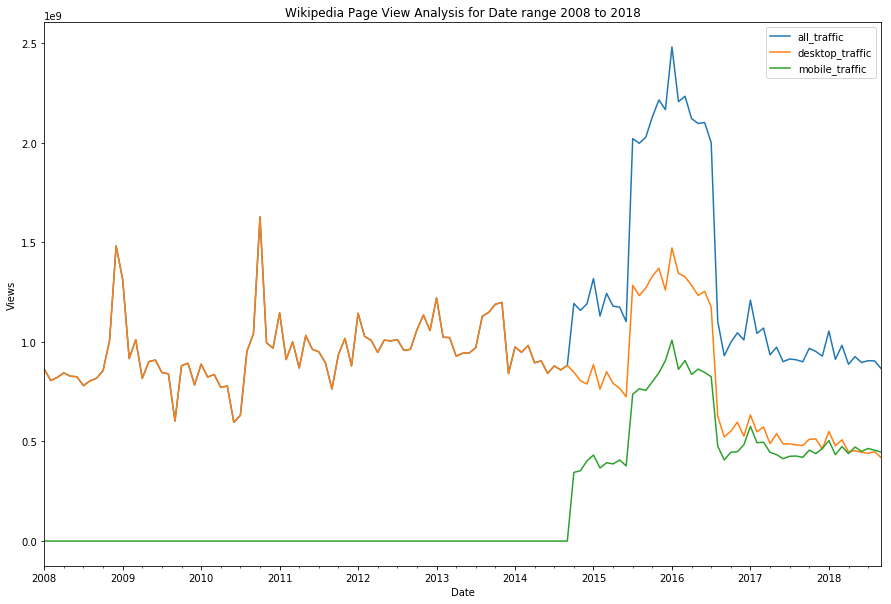

In [182]:
# Plotting time series view of the traffic at monthly level

analysis_df = final_csv_df.copy()
analysis_df['all_traffic'] = analysis_df['pageview_all_views'] + analysis_df['pagecount_all_views']
analysis_df['desktop_traffic'] = analysis_df['pagecount_desktop_views'] + analysis_df['pageview_desktop_views']
analysis_df['mobile_traffic'] = analysis_df['pagecount_mobile_views'] + analysis_df['pageview_mobile_views']
#analysis_df.plot(x='year', y=['all_traffic', 'desktop_traffic', 'mobile_traffic'], figsize=(15,10))

l1 = analysis_df['all_traffic'].values
l2 = analysis_df['desktop_traffic'].values
l3 = analysis_df['mobile_traffic'].values

timeseries = np.vstack((l1, l2, l3)).T

timeseries_df = pd.DataFrame(timeseries, index=pd.date_range(start='2008-01-01', end='2018-10-01', freq='M'), \
                             columns=['all_traffic','desktop_traffic','mobile_traffic'])

timeseries_df.plot(figsize=(15,10))
plt.title('Wikipedia Page View Analysis for Date range 2008 to 2018')
plt.xlabel('Date')
plt.ylabel('Views')

There is clear spike in overall traffic values around 2016. This could be explained by the fact that pagecounts were being phased out and pageviews were being introduced.